In [50]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [51]:
class MLP(nn.Module):
    def __init__(self,nin,nout,n_layers, width):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(nin,width))
        layers.append(nn.Tanh())
        for _ in range(n_layers-1):
            layers.append(nn.Linear(width,width))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(width,nout))
        layers.append(nn.Tanh())
        self.network=nn.Sequential(*layers)

    def forward(self,inputs):
        return self.network(inputs)

In [52]:
def gen_coll_pnts(nt,nx):
    t=torch.linspace(0,1,nt)
    x=torch.linspace(-1,1,nx)
    X,T = torch.meshgrid(x,t)
    points=torch.stack([T.reshape(-1),X.reshape(-1)],dim=1)
    points.requires_grad_(True)
    return points

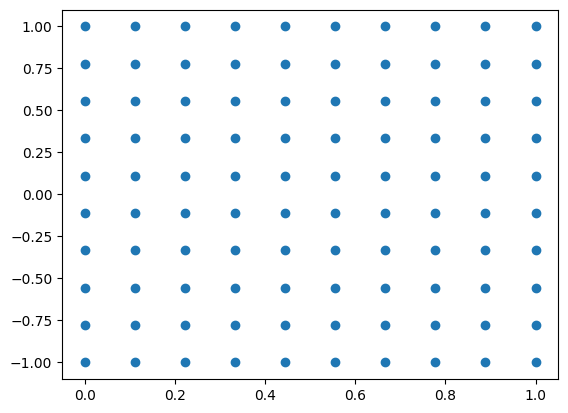

In [53]:
pnts = gen_coll_pnts(10,10)
t=pnts[:,0].detach().numpy()
x=pnts[:,1].detach().numpy()
plt.scatter(t,x)
plt.show()

In [54]:
def gen_bound_pnts(num_p):
    s_1 = torch.linspace(0,1,num_p)
    s_2 = torch.linspace(-1,1,num_p)
    t,x = torch.meshgrid(s_1,torch.tensor([1.0]))
    bu = torch.stack([t.reshape(-1),x.reshape(-1)],dim=1).requires_grad_(True)
    t,x = torch.meshgrid(s_1,torch.tensor([-1.0]))
    bd = torch.stack([t.reshape(-1),x.reshape(-1)],dim=1).requires_grad_(True)
    t,x = torch.meshgrid(torch.tensor([0.0]),s_2)
    bl = torch.stack([t.reshape(-1),x.reshape(-1)],dim=1).requires_grad_(True)
    return bu,bd,bl

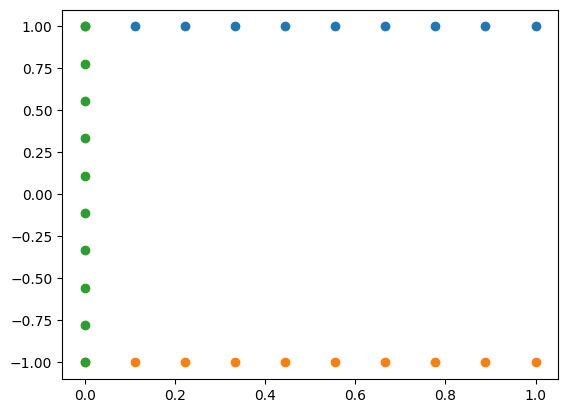

In [55]:
bu,bd,bl=gen_bound_pnts(10)

plt.scatter(bu[:,0].detach().numpy(),bu[:,1].detach().numpy())
plt.scatter(bd[:,0].detach().numpy(),bd[:,1].detach().numpy())
plt.scatter(bl[:,0].detach().numpy(),bl[:,1].detach().numpy())
plt.show()

In [56]:
def loss_boundary(model,bu,bd,bl):
    mu = model(bu)
    md = model(bd)
    ml = model(bl)
    lu = torch.mean(mu**2)
    ld = torch.mean(md**2)
    ll = torch.mean((ml+torch.sin(torch.pi*bl[:,1]))**2)
    return lu,ld,ll

In [57]:
def loss_residual(model,inputs):
    u=model(inputs)
    grad_u = torch.autograd.grad(u,inputs,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    dudt = grad_u[:,0]
    dudx = grad_u[:,1]
    d2udx2 = torch.autograd.grad(dudx,inputs,grad_outputs=torch.ones_like(dudt),create_graph=True)[0][:,1]

    return torch.mean((dudt+u*dudx-.01/torch.pi*d2udx2)**2)

In [71]:
pinn = MLP(2,1,9,20)
bound_size = 100

npts = 100
bu,bd,bl=gen_bound_pnts(npts)
t_coll = gen_coll_pnts(npts,npts)
epochs = 100
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

bu_loss = []
bd_loss = []
bl_loss = []
coll_loss = []
losses = []

beta1 = 1
beta2 = 1
for e in range(epochs):
    # print(f"Epoch {e+1}\n-------------------------------")
    optimizer.zero_grad()
    loss_coll = loss_residual(pinn,t_coll)
    lu,ld,ll = loss_boundary(pinn,bu,bd,bl)

    loss = beta1*loss_coll+beta2*(lu+ld+ll)

    coll_loss.append(loss_coll.item())
    bu_loss.append(lu.item())
    bd_loss.append(ld.item())
    bl_loss.append(ll.item())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
print(loss.item())

0.49500006437301636


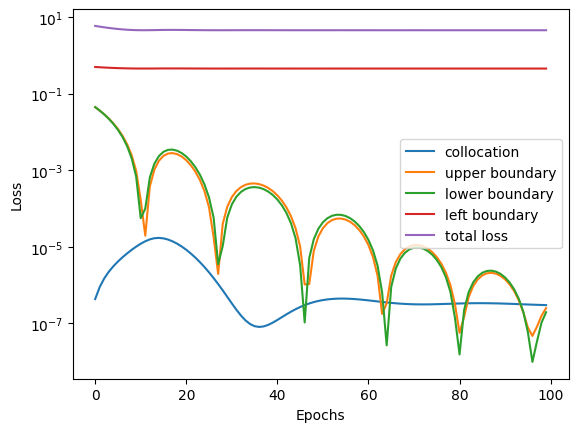

In [69]:
plt.figure()
plt.plot(range(epochs),coll_loss,label = 'collocation')
plt.plot(range(epochs),bu_loss,label = 'upper boundary')
plt.plot(range(epochs),bd_loss,label = 'lower boundary')
plt.plot(range(epochs),bl_loss,label = 'left boundary')
plt.plot(range(epochs),losses,label = 'total loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

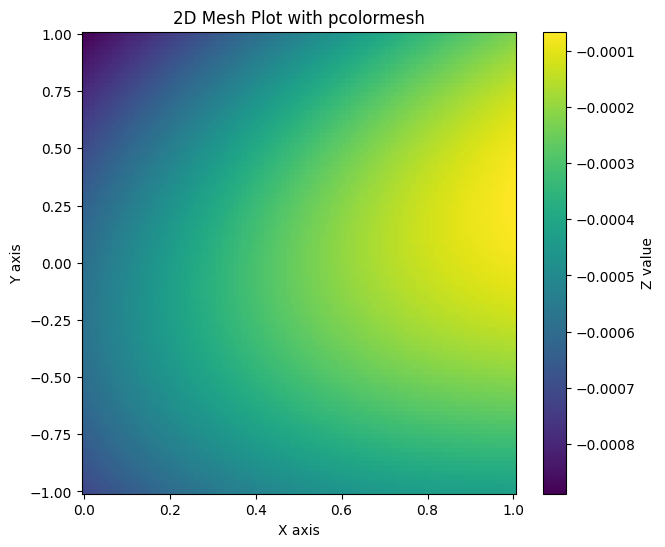

In [70]:
x = torch.linspace(-1,1,100)
t = torch.linspace(0,1,100)
X,T = torch.meshgrid(x,t,indexing='ij')
points=torch.stack([T.reshape(-1),X.reshape(-1)],dim=1)
Z = pinn(points)
Z = Z.reshape(100, 100)
plt.figure(figsize=(7, 6))
plt.pcolormesh(T.numpy(),X.numpy(), Z.detach().numpy(), cmap='viridis') #
plt.colorbar(label='Z value')
plt.title('2D Mesh Plot with pcolormesh')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()